In [1]:
library(h2o)
library(gbm)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc

Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1


In [2]:
# Connecting to the H20 Cluster consisting of frigg and odin. It has 64 logical processors.
library(h2o)
localH2O = h2o.init(port = 5777)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         6 days 4 hours 
    H2O cluster version:        3.10.4.1 
    H2O cluster version age:    12 days  
    H2O cluster name:           denis.perevalov 
    H2O cluster total nodes:    2 
    H2O cluster total memory:   23.02 GB 
    H2O cluster total cores:    64 
    H2O cluster allowed cores:  40 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        5777 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 3.3.2 (2016-10-31) 



In [8]:
## 'path' can point to a local file, hdfs, s3, nfs, Hive, directories, etc.
df.hex <- h2o.importFile(path = "http://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/titanic.csv")

## pick a response for the supervised problem
response        <- "survived"

# H2O GBM needs it to be a factor
response_factor <- paste0(response, "_factor")
## the response variable is an integer, we will turn it into a categorical/factor for binary classification
df.hex[[response_factor]] <- as.factor(df.hex[[response]])           

## use all other columns (except for the name) as predictors
predictors <- setdiff(names(df.hex), c(response, "name", response_factor)) 

  |======================================================================| 100%


In [9]:
# Predictors for GBM
predictors_gbm = predictors[8:9]
predictors_gbm

[1] "cabin"    "embarked"

In [10]:
# Predictors for GLM
predictors_glm = setdiff(predictors, predictors_gbm)
predictors_glm

[1] "pclass"    "sex"       "age"       "sibsp"     "parch"     "ticket"   
 [7] "fare"      "boat"      "body"      "home.dest"

In [11]:
# Build GLM. It's going to be the offset
glm_model <- h2o.glm(x = predictors_glm,
                     y     = "survived",
                     family="binomial",
                     training_frame = df.hex)


  |======================================================================| 100%


In [12]:
# Get Probabilities from GLM
df.hex$Probability     = h2o.predict(glm_model, newdata = df.hex)$p1
df.hex$ProbabilityLink = log(df.hex$Probability / (1.0 - df.hex$Probability))

  |======================================================================| 100%


In [14]:
# Maximum of link could be greater than 1
max(df.hex$ProbabilityLink)

[1] 2.128755

In [15]:
# Convert to R dataframe
df = as.data.frame(df.hex)

In [16]:
gbm_model <- gbm.fit(x=df[,predictors_gbm], y=df[[response]], distribution="bernoulli", offset=df[["ProbabilityLink"]], n.trees=1000)


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.9559             nan     0.0010    0.0000
     2        0.9558             nan     0.0010    0.0000
     3        0.9556             nan     0.0010    0.0000
     4        0.9554             nan     0.0010    0.0000
     5        0.9553             nan     0.0010    0.0000
     6        0.9551             nan     0.0010    0.0000
     7        0.9550             nan     0.0010    0.0000
     8        0.9548             nan     0.0010    0.0000
     9        0.9546             nan     0.0010    0.0000
    10        0.9545             nan     0.0010    0.0000
    20        0.9529             nan     0.0010    0.0000
    40        0.9499             nan     0.0010    0.0000
    60        0.9470             nan     0.0010    0.0000
    80        0.9441             nan     0.0010    0.0000
   100        0.9413             nan     0.0010    0.0000
   120        0.9387             nan     0.0010    0.0000
   140        

In [17]:
# get Probabilities
get_pred = function(model, data, type="response", offset=0, n.trees=1){
    if(class(model) == "gbm"){
        prediction = predict(model, newdata=data, type=type, n.trees = n.trees) + offset
        # If Link, convert it back to probability
        if(type == "link"){
            prediction = 1.0 / (1.0 + exp(-prediction))
        }
    }else{
        # H2O always predicts probabilities
        prediction = predict(model, newdata=data)$p1
    }
    prediction
}

# Negative Log Likelihood (Same as LogLoss)
# The lower - the better
get_nll = function(model, data, truth=NULL, offset=0, n.trees=1){
    if(is.null(truth)){
        truth = data$survived
    }
    
    prediction = get_pred(model=model, data=data, type="link", offset=offset, n.trees=n.trees)
    
    logprob    = log(prediction + 0.0000001)
    logprob2   = log(1.0 - prediction - 0.0000001)
    ytrue = as.numeric(truth)
    llk        = ytrue * logprob + (1.0 - ytrue) * logprob2
    -mean(llk)
}

In [18]:
# Calculate LogLoss for GBM
logloss = sapply(1:1000, function(x) get_nll(gbm_model, df[,predictors_gbm], truth=df$survived, offset = df$ProbabilityLink, n.trees=x))

  |======================================================================| 100%


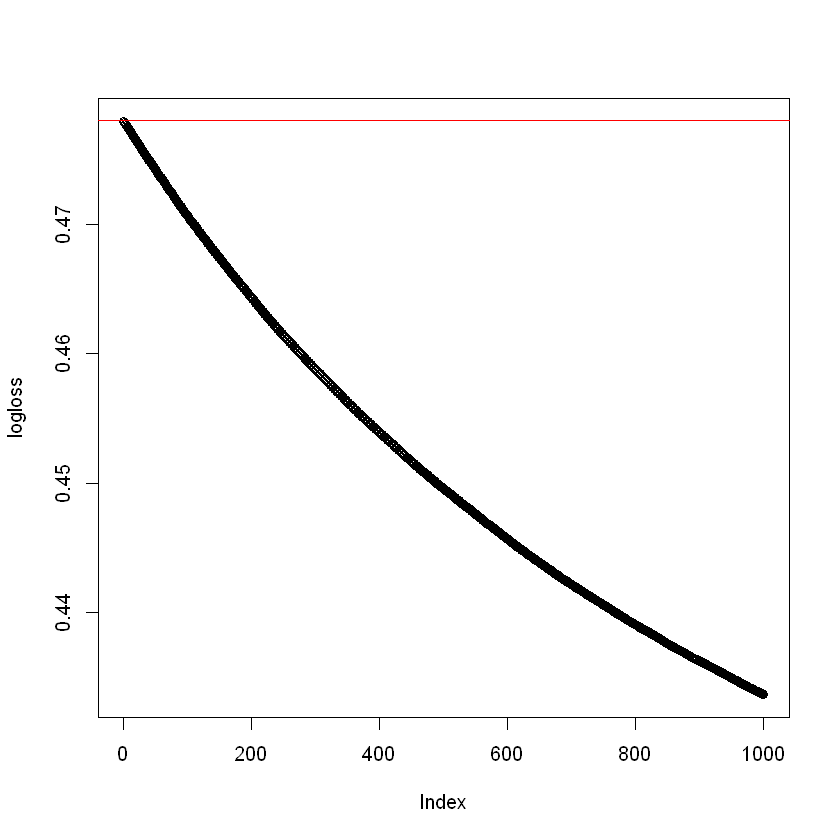

In [19]:
# Plot Log Loss for GBM as a function of trees
plot(logloss)
# Plot Log Loss for glm as red hirizontal line
abline(h=get_nll(glm_model, df.hex), col=2)

In [20]:
# Try to do the same for H2O GBM
h2o_gbm_model = h2o.gbm(x = predictors_gbm,
                         ,y                    = response_factor
                         ,distribution         = "bernoulli"
                         ,training_frame       = df.hex
                         ,ntrees               = 1
                         ,score_each_iteration = F
                         ,max_depth            = 4
                         ,learn_rate           = 0.000005
                         ,offset_column        = "ProbabilityLink"
)

  |                                                                      |   0%

water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_model_R_1489164084643_3576.  Details: ERRR on field: _offset_column: Offset cannot be larger than 1 for Bernoulli distribution.


water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_model_R_1489164084643_3576.  Details: ERRR on field: _offset_column: Offset cannot be larger than 1 for Bernoulli distribution.

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree$Driver.computeImpl(SharedTree.java:173)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:169)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1192)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(

ERROR: Error: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_model_R_1489164084643_3576.  Details: ERRR on field: _offset_column: Offset cannot be larger than 1 for Bernoulli distribution.


So, why is that **Offset cannot be larger than 1 for Bernoulli distribution**?